### Setup

In [ ]:
%pip -q install keras

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from keras import layers
from keras.datasets import mnist
from keras.models import Model


def preprocess(array):
    """Normalizes the supplied array and reshapes it."""
    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array


def noise(array):
    """Adds random noise to each image in the supplied array."""
    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


def display(array1, array2):
    """Displays ten random images from each array."""
    n = 10
    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

def to_rgb(array, labels):
    """Converts the supplied array to an RGB image."""
    new_array = np.zeros((len(array), 28, 28, 3))
    

2024-09-05 21:01:01.206370: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-05 21:01:01.207219: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-05 21:01:01.209543: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-05 21:01:01.216663: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-05 21:01:01.228850: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

### Prepare the data

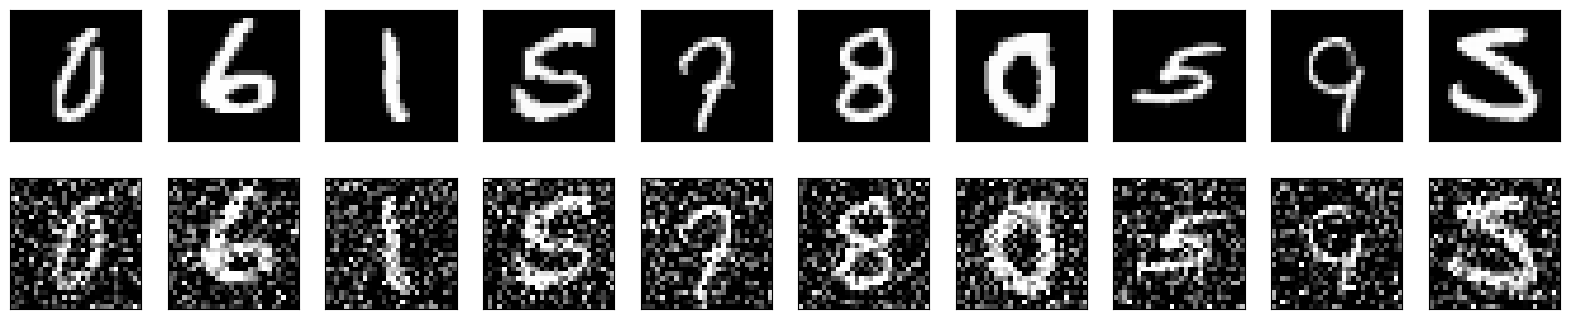

In [2]:
# Since we only need images from the dataset to encode and decode, we
# won't use the labels.
(train_data, train_label), (test_data, _) = mnist.load_data()

# Normalize and reshape the data
train_data = preprocess(train_data)
test_data = preprocess(test_data)

# Create a copy of the data with added noise
noisy_train_data = noise(train_data) #sub for to_rgb
noisy_test_data = noise(test_data)

# Display the train data and a version of it with added noise
display(train_data, noisy_train_data)

### Build the autoencoder

In [3]:
input = layers.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x) # Put filters=3 for RGB

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

I0000 00:00:1725580876.306568   18275 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-05 21:01:16.337714: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,353 (110.75 KB)

 Trainable params: 28,353 (110.75 KB)

 Non-trainable params: 0 (0.00 B)

Now we can train our autoencoder using train_data as both our input data and target. Notice we are setting up the validation data using the same format.

In [4]:
autoencoder.fit(
    x=train_data,
    y=train_data, # color_images,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(test_data, test_data),
)

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.2393 - val_loss: 0.0734
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0731 - val_loss: 0.0696
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0698 - val_loss: 0.0682
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0684 - val_loss: 0.0674
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0676 - val_loss: 0.0667
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0670 - val_loss: 0.0661
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0665 - val_loss: 0.0657
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0660 - val_loss: 0.0654
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0656 - val_loss: 0.0651
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0654 - val_loss: 0.0649
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0651 - val_loss: 0.0645
Epoch 12/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 

Let's predict on our test dataset and display the original image together with the prediction from our autoencoder.

Notice how the predictions are pretty close to the original images, although not quite the same.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


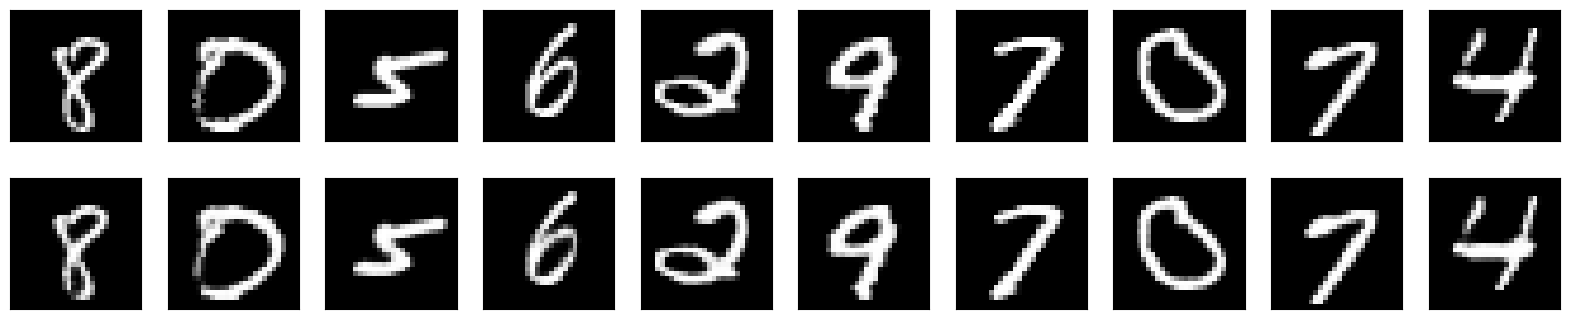

In [5]:
predictions = autoencoder.predict(test_data)
display(test_data, predictions)

Now that we know that our autoencoder works, let's retrain it using the noisy data as our input and the clean data as our target. We want our autoencoder to learn how to denoise the images.

In [6]:
autoencoder.fit(
    x=noisy_train_data,
    y=train_data,
    epochs=100,
    batch_size=128,
    shuffle=True,
    validation_data=(noisy_test_data, test_data),
)

Epoch 1/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.1162 - val_loss: 0.0940
Epoch 2/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0938 - val_loss: 0.0917
Epoch 3/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0919 - val_loss: 0.0905
Epoch 4/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.0909 - val_loss: 0.0902
Epoch 5/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0902 - val_loss: 0.0891
Epoch 6/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.0896 - val_loss: 0.0887
Epoch 7/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.0890 - val_loss: 0.0883
Epoch 8/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0887 - val_loss: 0.0879
Epoch 9/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0885 - val_loss: 0.0877
Epoch 10/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.0881 - val_loss: 0.0874
Epoch 11/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.0877 - val_loss: 0.0872
Epoch 12/100
469/469 ━━━━━━

Let's now predict on the noisy data and display the results of our autoencoder.

Notice how the autoencoder does an amazing job at removing the noise from the input images.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


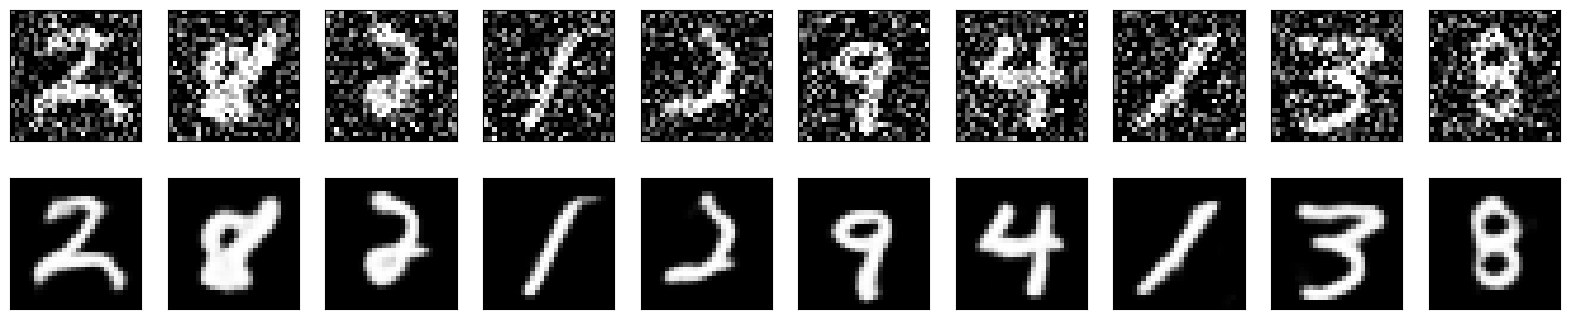

In [7]:
predictions = autoencoder.predict(noisy_test_data)
display(noisy_test_data, predictions)